# Elo Merchant Category Recommendation - Customers with zero target <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv("input/train.csv")
df = reduce_mem_usage(df)

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)


In [4]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [5]:
df_trans = pd.concat([df_hist_trans, df_new_trans])
df_trans = df_trans[df_trans['card_id'].isin(df['card_id'].unique())].reset_index()
df_trans.head(3)

,index,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,400,N,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37
1,401,Y,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19
2,402,Y,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33


According to [this kernel](https://www.kaggle.com/raddar/target-true-meaning-revealed), the true target is $2^{loyalty}$, and it corresponds to a quotient between the past purchased amount and the future amount. Then the users which only purchase a fixed amount (maybe monthly subscriptions) would have a quotient equal to 1, which translates to a 0 loyalty score. <br>
Taking this into account, maybe the high bar that we can see (below) at zero in the targets histogram is due to a big amount of monthly users.

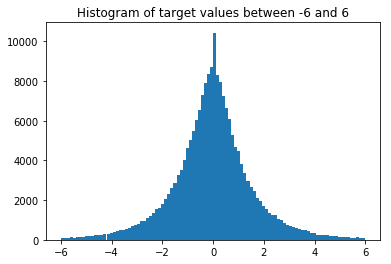

In [14]:
plt.hist(df[(df['target']>(-6)) & (df['target']<6)]['target'], bins=100)
plt.title("Histogram of target values between -6 and 6")
plt.show()

In [23]:
df_trans['purchase_amount_raw'] = df_trans['purchase_amount']/0.00150265118 + 497.06
df_trans = df_trans[df_trans['authorized_flag']=='Y'] #We will only use authorized transactions
df['target_raw'] = 2**df['target']

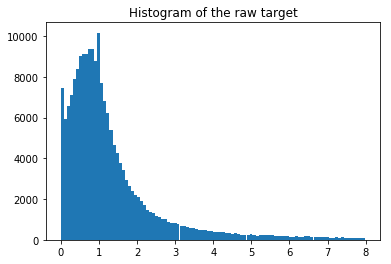

In [26]:
plt.hist(df[df['target_raw']<8]['target_raw'], bins=100)
plt.title("Histogram of the raw target")
plt.show()

For the raw target we can see that the outliers bar has transformed to a higher bar in zero, and the bar that concerns us is now at 1. <br>
Let's isolate the transactions of these users and derive some "uniqueness" measure.

# First approach to a "uniqueness" measure

In [30]:
df_trans_zeros = df_trans[df_trans['card_id'].isin(df[df['target']==0]['card_id'].values)]

In [37]:
df_unique_amounts = df_trans_zeros.groupby(['card_id', 'merchant_id'])['purchase_amount_raw'].nunique().reset_index().rename(columns={'purchase_amount_raw': 'unique_amounts'})
df_unique_amounts.head()

,card_id,merchant_id,unique_amounts
0,C_ID_0015cb7ed9,M_ID_00a6ca8a8a,2
1,C_ID_0015cb7ed9,M_ID_08852c20d5,1
2,C_ID_0015cb7ed9,M_ID_1570421660,1
3,C_ID_0015cb7ed9,M_ID_16ecc67fdc,1
4,C_ID_0015cb7ed9,M_ID_21a5a5729c,1


In [42]:
df_n_trans = df_trans_zeros.groupby(['card_id', 'merchant_id']).size().reset_index().rename(columns={0: 'n_trans'})
df_n_trans.head()

,card_id,merchant_id,n_trans
0,C_ID_0015cb7ed9,M_ID_00a6ca8a8a,2
1,C_ID_0015cb7ed9,M_ID_08852c20d5,1
2,C_ID_0015cb7ed9,M_ID_1570421660,1
3,C_ID_0015cb7ed9,M_ID_16ecc67fdc,1
4,C_ID_0015cb7ed9,M_ID_21a5a5729c,1


We want to measure if, for the merchants used by the customer, all the purchased amounts are the same. <br> 
We will take the mean of $\frac{\text{unique_amounts}-1}{\text{n_trans}}$. Then, if a user has exactly a zero value for this measure, it means that she/he only performed transactions with unique values.

In [44]:
df_unique_temp = df_unique_amounts.merge(df_n_trans, on=['card_id','merchant_id'])
df_unique_temp['quotient'] = (df_unique_temp['unique_amounts']-1)/df_unique_temp['n_trans']
df_unique_temp.head()

,card_id,merchant_id,unique_amounts,n_trans,quotient
0,C_ID_0015cb7ed9,M_ID_00a6ca8a8a,2,2,0.5
1,C_ID_0015cb7ed9,M_ID_08852c20d5,1,1,0.0
2,C_ID_0015cb7ed9,M_ID_1570421660,1,1,0.0
3,C_ID_0015cb7ed9,M_ID_16ecc67fdc,1,1,0.0
4,C_ID_0015cb7ed9,M_ID_21a5a5729c,1,1,0.0


In [48]:
df_unique = df_unique_temp.groupby('card_id')['quotient'].mean().reset_index().rename(columns={'quotient': 'uniqueness'})
df_unique.head()

,card_id,uniqueness
0,C_ID_0015cb7ed9,0.170290
1,C_ID_00167ca6d8,0.218750
2,C_ID_001de6764b,0.240278
3,C_ID_00699c00e4,0.352273
4,C_ID_00702986e6,0.214286


We see that there are users with "uniqueness" measure greater than zero (us expected), but there are also some of them with exactly zero measure.

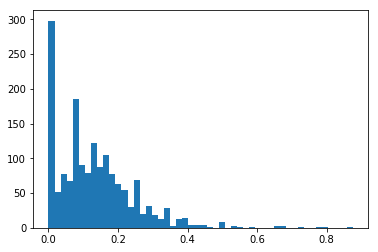

In [55]:
plt.hist(df_unique['uniqueness'], bins=50)
plt.show()

We can see that, in fact, a good part of the users with zero target have also zero "uniqueness" measure.

Let's check the opossite: if all users with zero "uniqueness" measure have zero target.

In [56]:
df_unique_amounts_all = df_trans.groupby(['card_id', 'merchant_id'])['purchase_amount_raw'].nunique().reset_index().rename(columns={'purchase_amount_raw': 'unique_amounts'})
df_n_trans_all = df_trans.groupby(['card_id', 'merchant_id']).size().reset_index().rename(columns={0: 'n_trans'})
df_unique_temp_all = df_unique_amounts_all.merge(df_n_trans_all, on=['card_id','merchant_id'])
df_unique_temp_all['quotient'] = (df_unique_temp_all['unique_amounts']-1)/df_unique_temp_all['n_trans']
df_unique_all = df_unique_temp_all.groupby('card_id')['quotient'].mean().reset_index().rename(columns={'quotient': 'uniqueness'})

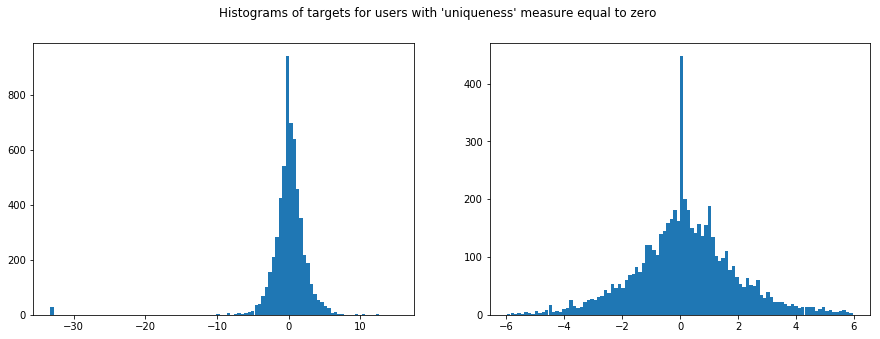

In [69]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df[df['card_id'].isin(df_unique_all[df_unique_all['uniqueness']==0]['card_id'].values)]['target'], bins=100)
plt.subplot(1,2,2)
plt.hist(df[(df['card_id'].isin(df_unique_all[df_unique_all['uniqueness']==0]['card_id'].values)) & (df['target']>(-6)) & (df['target']<6)]['target'], bins=100)
plt.suptitle("Histograms of targets for users with 'uniqueness' measure equal to zero")
plt.show()

We can see that with this "uniqueness" measure we can, more or less, detect the users with zero target. But we have to refine it more since we still can not isolate them.

# Refine the uniqueness measure
Let's divide the users with zero "uniqueness" into the ones that have zero target and the ones that not, to see if we can identify some pattern to refine our measure.

In [73]:
df = df.merge(df_unique_all, on='card_id')

In [75]:
zero_u = df[(df['uniqueness']==0) & (df['target']==0)]['card_id'].values
nonzero_u = df[(df['uniqueness']==0) & (df['target']!=0)]['card_id'].values

## Only merchants with more than one tracsaction
Maybe, in order to be a valid uniqueness measure, we need to have more than one transaction per merchant. So let's compute the number of different merchants for the "nonzero_u" group, compared with the number of total transactions of the customer.

In [82]:
df_nonzero_u_temp1 = df_trans[df_trans['card_id'].isin(nonzero_u)].groupby('card_id')['merchant_id'].nunique().reset_index().rename(columns={'merchant_id': 'n_merch'})
df_nonzero_u_temp2 = df_n_trans_all.groupby('card_id')['n_trans'].sum().reset_index()

In [87]:
df_nonzero_u_merch = df_nonzero_u_temp1.merge(df_nonzero_u_temp2, on="card_id")
df_nonzero_u_merch['prop_unique_merch'] = df_nonzero_u_merch['n_merch']/df_nonzero_u_merch['n_trans']
df_nonzero_u_merch.head()

,card_id,n_merch,n_trans,prop_unique_merch
0,C_ID_0004b68c49,7,7,1.0
1,C_ID_0011c836e7,14,14,1.0
2,C_ID_003904d29f,24,24,1.0
3,C_ID_0048a85a3f,6,6,1.0
4,C_ID_00497a9040,8,8,1.0


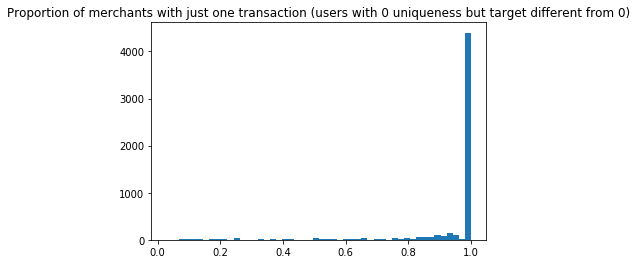

In [92]:
plt.hist(df_nonzero_u_merch['prop_unique_merch'], bins=50)
plt.title("Proportion of merchants with just one transaction (users with 0 uniqueness but target different from 0)")
plt.show()

In view of this histogram it seems clear that, in order to get a good "uniqueness" measure we have to first remove the merchants with just one trasaction. So let's repeat the analysis of the previous section but removing such transactions from the computation.

In [133]:
df_unique_all_refined = df_unique_temp_all[df_unique_temp_all['n_trans']>1].groupby('card_id')['quotient'].mean().reset_index().rename(columns={'quotient': 'uniqueness'})
df_unique_all_refined.head()

,card_id,uniqueness
0,C_ID_00007093c1,0.601541
1,C_ID_0001506ef0,0.563696
2,C_ID_000183fdda,0.547236
3,C_ID_00027503e2,0.579545
4,C_ID_0002c7c2c1,0.615741


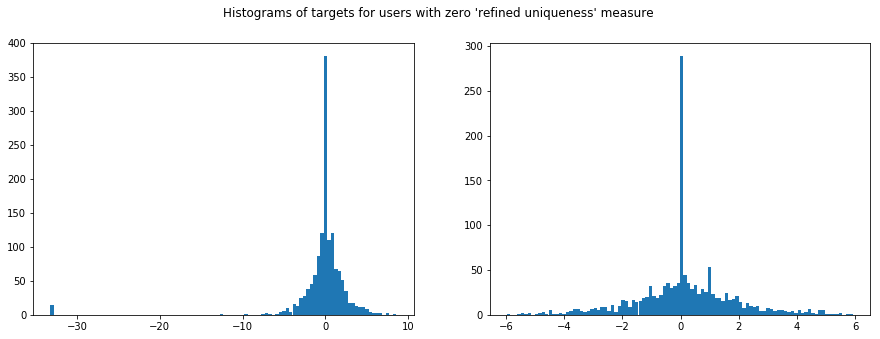

In [110]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df[df['card_id'].isin(df_unique_all_refined[df_unique_all_refined['uniqueness']==0]['card_id'].values)]['target'], bins=100)
plt.subplot(1,2,2)
plt.hist(df[(df['card_id'].isin(df_unique_all_refined[df_unique_all_refined['uniqueness']==0]['card_id'].values)) & (df['target']>(-6)) & (df['target']<6)]['target'], bins=100)
plt.suptitle("Histograms of targets for users with zero 'refined uniqueness' measure")
plt.show()

We are now able to much better isolate the customers with exactly zero target, but there is still something missing. The bound (now 1) on the number of transaction does not influence the meassure any more, since the histogram does not improve when increasing it. <br> 
However we have to take into account that we are not seeing the whole data set, so maybe these customers have zero uniquenes measure according to our portion of the data set, but not if we could see the whole data set of transactions.

## Weight the mean with the number of transactions
We see that when increasing a little bit the "uniqueness" cut-off we detect more users with zero target:

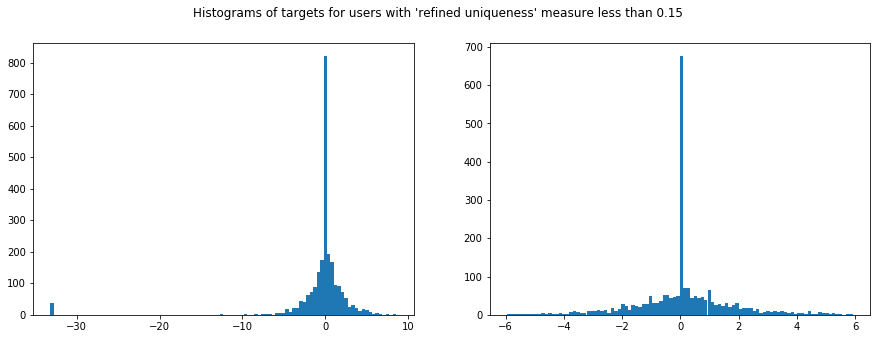

In [149]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df[df['card_id'].isin(df_unique_all_refined[df_unique_all_refined['uniqueness']<=0.15]['card_id'].values)]['target'], bins=100)
plt.subplot(1,2,2)
plt.hist(df[(df['card_id'].isin(df_unique_all_refined[df_unique_all_refined['uniqueness']<=0.15]['card_id'].values)) & (df['target']>(-6)) & (df['target']<6)]['target'], bins=100)
plt.suptitle("Histograms of targets for users with 'refined uniqueness' measure less than 0.15")
plt.show()

This may indicate that the uniqueness measure is computed only for relevant merchants, or maybe that the mean among merchants should be weighted according with the number of transactions. 
But since the quotient is computed as $\frac{\text{unique_amounts}-1}{\text{n_trans}}$, if we weight the mean with n_trans we are basically taking the sum of unique_amounts-1 and dividing it by the total number of transactions of the user.

In [158]:
df_unique_all_refinedW = df_unique_temp_all[df_unique_temp_all['n_trans']>1].groupby('card_id').apply(lambda dfx: (dfx['unique_amounts']-1).sum() / dfx['n_trans'].sum())

In [159]:
df_unique_all_refinedW = df_unique_all_refinedW.reset_index().rename(columns={0: 'uniqueness'})
df_unique_all_refinedW.head()

,card_id,uniqueness
0,C_ID_00007093c1,0.574257
1,C_ID_0001506ef0,0.674419
2,C_ID_000183fdda,0.627660
3,C_ID_00027503e2,0.705882
4,C_ID_0002c7c2c1,0.689655


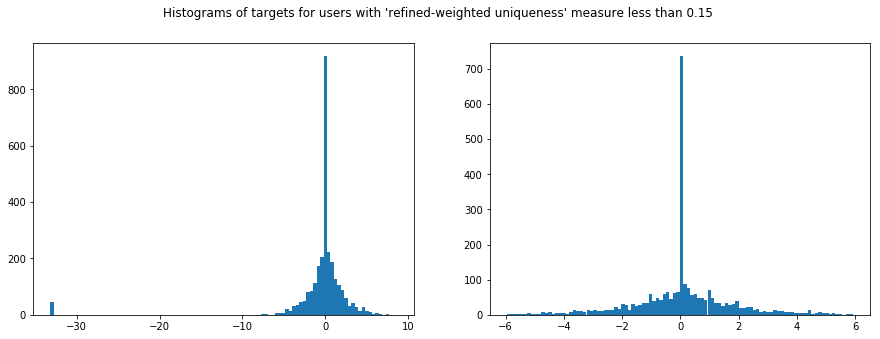

In [170]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df[df['card_id'].isin(df_unique_all_refinedW[df_unique_all_refinedW['uniqueness']<=0.15]['card_id'].values)]['target'], bins=100)
plt.subplot(1,2,2)
plt.hist(df[(df['card_id'].isin(df_unique_all_refinedW[df_unique_all_refinedW['uniqueness']<=0.15]['card_id'].values)) & (df['target']>(-6)) & (df['target']<6)]['target'], bins=100)
plt.suptitle("Histograms of targets for users with 'refined-weighted uniqueness' measure less than 0.15")
plt.show()

It seems that we have improved a little bit, since we are able to detect more users with zero target.

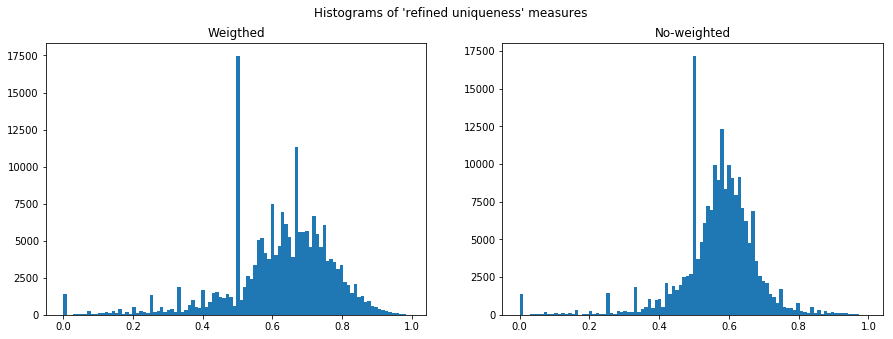

In [171]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df_unique_all_refinedW['uniqueness'], bins=100)
plt.title('Weigthed')
plt.subplot(1,2,2)
plt.hist(df_unique_all_refined['uniqueness'], bins=100)
plt.title('No-weighted')
plt.suptitle("Histograms of 'refined uniqueness' measures")
plt.show()

The measure without weights seems to have a "smoother" histogram. Besides I don't know what the bar in 0.5 means. Maybe there are a lot of users with just two transactions per merchant (due to the 3-months restriction).

## Only for favourite merchant

In [173]:
df_unique_all_refinedF = df_unique_temp_all[df_unique_temp_all['n_trans']>1].groupby('card_id').apply(lambda dfx: dfx.ix[dfx['n_trans'].idxmax()]['quotient'])
df_unique_all_refinedF.head()

card_id
C_ID_00007093c1    0.806452
C_ID_0001506ef0    0.692308
C_ID_000183fdda    0.916667
C_ID_00027503e2    0.818182
C_ID_0002c7c2c1    0.875000
dtype: float64

In [174]:
df_unique_all_refinedF = df_unique_all_refinedF.reset_index().rename(columns={0: 'uniqueness'})
df_unique_all_refinedF.head()

,card_id,uniqueness
0,C_ID_00007093c1,0.806452
1,C_ID_0001506ef0,0.692308
2,C_ID_000183fdda,0.916667
3,C_ID_00027503e2,0.818182
4,C_ID_0002c7c2c1,0.875000


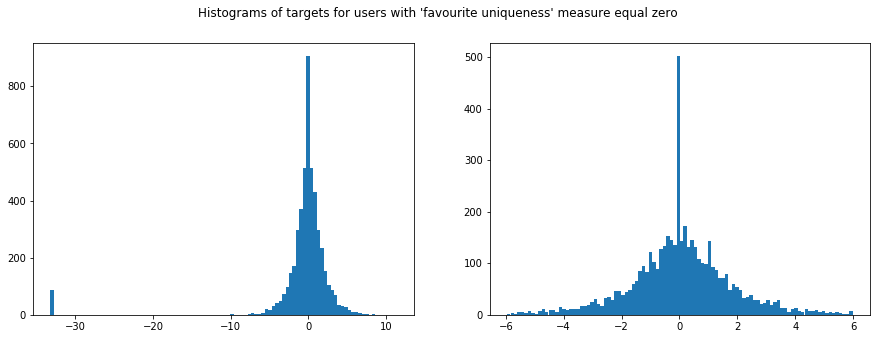

In [177]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df[df['card_id'].isin(df_unique_all_refinedF[df_unique_all_refinedF['uniqueness']==0]['card_id'].values)]['target'], bins=100)
plt.subplot(1,2,2)
plt.hist(df[(df['card_id'].isin(df_unique_all_refinedF[df_unique_all_refinedF['uniqueness']==0]['card_id'].values)) & (df['target']>(-6)) & (df['target']<6)]['target'], bins=100)
plt.suptitle("Histograms of targets for users with 'favourite uniqueness' measure equal zero")
plt.show()

It got worst, so we discard this approach.

# Standard deviation to meassure uniqueness
We could also use the standard deviation of the purchased amount to measure the "uniqueness" of these quantities.

In [180]:
df_trans_std = df_trans.groupby(['card_id','merchant_id'])['purchase_amount'].std().reset_index()

In [182]:
df_trans_std = df_trans_std.rename(columns={'purchase_amount':'amount_std'})
df_trans_std.head()

,card_id,merchant_id,amount_std
0,C_ID_00007093c1,M_ID_00a6ca8a8a,NaN
1,C_ID_00007093c1,M_ID_0379adb435,0.116543
2,C_ID_00007093c1,M_ID_06a8d84366,NaN
3,C_ID_00007093c1,M_ID_08f01305af,NaN
4,C_ID_00007093c1,M_ID_0dabc5a70c,0.054721


In [186]:
df_trans_std = df_trans_std.merge(df_unique_temp_all[['card_id','merchant_id','n_trans']], on=['card_id','merchant_id'])
df_trans_std.head()

,card_id,merchant_id,amount_std,n_trans
0,C_ID_00007093c1,M_ID_00a6ca8a8a,NaN,1
1,C_ID_00007093c1,M_ID_0379adb435,0.116543,4
2,C_ID_00007093c1,M_ID_06a8d84366,NaN,1
3,C_ID_00007093c1,M_ID_08f01305af,NaN,1
4,C_ID_00007093c1,M_ID_0dabc5a70c,0.054721,2


As before, we will weight the std with the number of transaction performed for each merchant.

In [191]:
df_stdW = df_trans_std[df_trans_std['n_trans']>1].groupby('card_id').apply(lambda dfx: (dfx['amount_std']*dfx['n_trans']).sum() / dfx['n_trans'].sum())

In [195]:
df_stdW = df_stdW.reset_index().rename(columns={0:'std_weighted'})
df_stdW.head()

,card_id,std_weighted
0,C_ID_00007093c1,0.090292
1,C_ID_0001506ef0,0.259731
2,C_ID_000183fdda,0.182957
3,C_ID_00027503e2,0.002251
4,C_ID_0002c7c2c1,0.025889


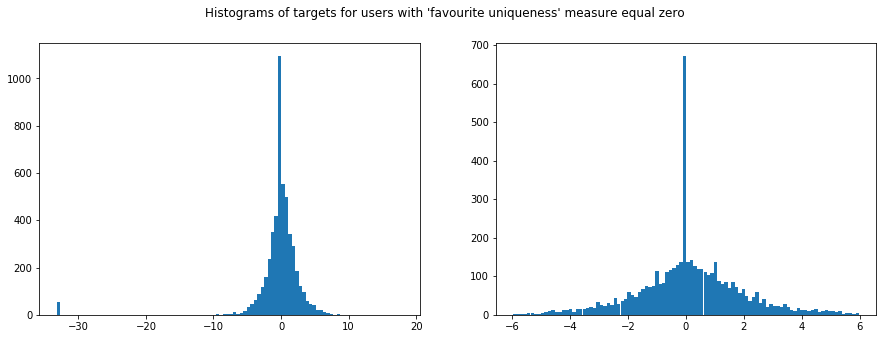

In [209]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df[df['card_id'].isin(df_stdW[df_stdW['std_weighted']<=0.005]['card_id'].values)]['target'], bins=100)
plt.subplot(1,2,2)
plt.hist(df[(df['card_id'].isin(df_stdW[df_stdW['std_weighted']<=0.005]['card_id'].values)) & (df['target']>(-6)) & (df['target']<6)]['target'], bins=100)
plt.suptitle("Histograms of targets for users with 'favourite uniqueness' measure equal zero")
plt.show()

From this histogram we can see that this approach is worst than the weighted mean of the uniqueness measure.

# Get optimal cut-off for the weighted mean of uniqueness measure
The best approach among the tested ones was to take the wieghted mean of quotients. But then the uniqueness measure is not exactly zero, so let's try to find the best cut-off point that allows us to find the higher number os users with zero value without adding too many of the rest.

In [219]:
df_unique_all_refinedW.rename(columns={'uniqueness':'uniquenessW'}, inplace=True)
df = df.merge(df_unique_all_refinedW, on='card_id', how='left')
df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_raw,uniqueness,uniquenessW
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,0.566406,0.175408,0.737705
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,1.312500,0.191013,0.672065
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,1.611328,0.152015,0.903226
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,1.103516,0.108118,0.615385
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,0.895020,0.084748,0.721519


In [253]:
cuts = np.linspace(1/101,0.2,101)
props = [0]*len(cuts)
for i in range(len(cuts)):
    cut = cuts[i]
    props[i] = df[(df['uniquenessW']<cut) & (df['target']==0)].shape[0]/df[(df['uniquenessW']<cut) & (df['target']!=0)].shape[0]

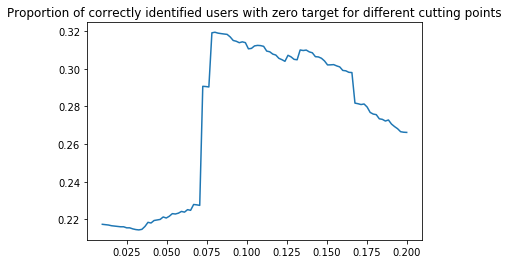

In [254]:
plt.plot(cuts,props)
plt.title("Proportion of correctly identified users with zero target for different cutting points")
plt.show()

In [259]:
cut_opt = cuts[props.index(max(props))].round(3)
print("Optimal cutting point for the weighted uniqueness measure: {}".format(cut_opt))

Optimal cutting point for the weighted uniqueness measure: 0.08


# Store the results
So let's now mark the users with uniqueness measure less than 0.08 also for the test set and store the results.

In [280]:
df['subscriber'] = 1*(df['uniquenessW']<cut_opt)
df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_raw,uniqueness,uniquenessW,subscriber
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,0.566406,0.175408,0.737705,0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,1.312500,0.191013,0.672065,0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,1.611328,0.152015,0.903226,0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,1.103516,0.108118,0.615385,0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,0.895020,0.084748,0.721519,0


In [264]:
df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)


In [265]:
df_trans_test = pd.concat([df_hist_trans, df_new_trans])
df_trans_test = df_trans_test[df_trans_test['card_id'].isin(df_test['card_id'].unique())].reset_index()
df_trans_test = df_trans_test[df_trans_test['authorized_flag']=='Y'] #We will only use authorized transactions

In [266]:
df_unique_amounts_all_test = df_trans_test.groupby(['card_id', 'merchant_id'])['purchase_amount'].nunique().reset_index().rename(columns={'purchase_amount': 'unique_amounts'})
df_n_trans_all_test = df_trans_test.groupby(['card_id', 'merchant_id']).size().reset_index().rename(columns={0: 'n_trans'})
df_unique_test = df_unique_amounts_all_test.merge(df_n_trans_all_test, on=['card_id','merchant_id'])

In [268]:
df_unique_testW = df_unique_test[df_unique_test['n_trans']>1].groupby('card_id').apply(lambda dfx: (dfx['unique_amounts']-1).sum() / dfx['n_trans'].sum())
df_unique_testW = df_unique_testW.reset_index().rename(columns={0: 'uniqueness'})
df_unique_testW.head()

,card_id,uniqueness
0,C_ID_0001238066,0.746269
1,C_ID_0001793786,0.696078
2,C_ID_00024e244b,0.687500
3,C_ID_0002709b5a,0.711111
4,C_ID_000298032a,0.538462


In [269]:
df_unique_testW.rename(columns={'uniqueness':'uniquenessW'}, inplace=True)
df_test = df_test.merge(df_unique_testW, on='card_id', how='left')
df_test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,uniquenessW
0,2017-04,C_ID_0ab67a22ab,3,3,1,0.586207
1,2017-01,C_ID_130fd0cbdd,2,3,0,0.676923
2,2017-08,C_ID_b709037bc5,5,1,1,0.666667
3,2017-12,C_ID_d27d835a9f,2,1,0,0.600000
4,2015-12,C_ID_2b5e3df5c2,5,1,1,0.586207


In [283]:
df_test['subscriber'] = 1*(df_test['uniquenessW']<cut_opt)
df_test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,uniquenessW,subscriber
0,2017-04,C_ID_0ab67a22ab,3,3,1,0.586207,0
1,2017-01,C_ID_130fd0cbdd,2,3,0,0.676923,0
2,2017-08,C_ID_b709037bc5,5,1,1,0.666667,0
3,2017-12,C_ID_d27d835a9f,2,1,0,0.600000,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1,0.586207,0


Store the results as csv files.

In [285]:
sub_df = pd.DataFrame({
    "card_id": df["card_id"].values
})

sub_df['subscriber'] = df['subscriber']
sub_df.to_csv("output/subscribers_train.csv", index=False)

In [286]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df['subscriber'] = df_test['subscriber']
sub_df.to_csv("output/subscribers_test.csv", index=False)